In [1]:
from interface import ox
import pandas as pd 
from helpers import plots 
import seaborn as sns
import logging 
import numpy as np 

ox_loader = ox.OxDataCollector()

In [ ]:
# get tickers that are within 1% of the 24h high 
def get_tickers_close_to_24h_high(tickers):
    close_to_24h_high = []
    for idx, ticker in tickers.iterrows():
        if float(ticker['lastTradedPrice']) >= float(ticker['high24h']) * 0.99:
            close_to_24h_high.append(ticker)

    # flatten and return 
    close_to_24h_high = pd.DataFrame(close_to_24h_high)
    return close_to_24h_high

# calc rolling 24h high 
def get_rolling_24h_high(ohlcv):
    rolling_highs = []
    for marketCode in ohlcv['marketCode'].unique():
        ohlcv_marketCode = ohlcv[ohlcv['marketCode'] == marketCode].copy() 
        ohlcv_marketCode['rolling_high'] = ohlcv_marketCode['close'].rolling(window=24).max()
        rolling_highs.append(ohlcv_marketCode)
    return pd.concat(rolling_highs)

# calculate next period, 12h, 24h return for each marketCode
def get_next_period_returns(ohlcv):
    returns = []
    for marketCode in ohlcv['marketCode'].unique():
        ohlcv_marketCode = ohlcv[ohlcv['marketCode'] == marketCode].copy() 
        # order ascending by openedAt 
        # ohlcv_marketCode = ohlcv_marketCode.sort_values(by='openedAt', ascending=True)
        ohlcv_marketCode['next_period_return'] = ohlcv_marketCode['close'].pct_change().shift(-1)
        ohlcv_marketCode['next_12h_return'] = ohlcv_marketCode['close'].pct_change(periods=12).shift(-12)   
        ohlcv_marketCode['next_24h_return'] = ohlcv_marketCode['close'].pct_change(periods=24).shift(-24)
        returns.append(ohlcv_marketCode)
    return pd.concat(returns)

# Calc historical_high 
def get_historical_high(ohlcv):
    historical_highs = []
    for marketCode in ohlcv['marketCode'].unique():
        ohlcv_marketCode = ohlcv[ohlcv['marketCode'] == marketCode].copy()
        ohlcv_marketCode['historical_high'] = ohlcv_marketCode['close'].shift(1).cummax()
        historical_highs.append(ohlcv_marketCode)
    return pd.concat(historical_highs)

In [2]:
tickers = ox_loader.getTickers()

In [ ]:
# Get tickers close to their 24h high according to the last TRADED px 
close_to_24h_high = get_tickers_close_to_24h_high(tickers)

# drop tickers with no volume 
close_to_24h_high = close_to_24h_high[close_to_24h_high['currencyVolume24h'].astype(float) > 1]
# convert lastUpdatedAt to datetime
# close_to_24h_high['lastUpdatedAt'] = pd.to_datetime(close_to_24h_high['lastUpdatedAt'].astype(float), unit='ms', origin='unix')

close_to_24h_high

,marketCode,markPrice,open24h,high24h,low24h,volume24h,currencyVolume24h,openInterest,lastTradedPrice,lastTradedQuantity,lastUpdatedAt
35,AICMP-USD-SWAP-LIN,0.043437,0.042333,0.053182,0.040426,51803.1297000,11641.0,1549.0,0.052808,1549.0,1736342082133
58,1000BOBO-USD-SWAP-LIN,0.0009158,0.0009109,0.0009568,0.0009080,7920.26400000,83600.0,32378500.0,0.00095,83600.0,1736342082268
82,ZEC-USD-SWAP-LIN,50.926,52.474,53.365,50.552,77205.75600,14.52,43.07,52.87,1.72,1736342082220
104,1000BEERCOIN-USD-SWAP-LIN,0.009138,0.009589,0.009611,0.009037,1930.1240000,2030.0,194580.0,0.009515,2030.0,1736342082032
105,MILK-OX,0.035,0.035,0.035,0.035,2007.4250,57355.0,0,0.035,53.0,1736342082246
107,NOT-USD-SWAP-LIN,0.005935,0.006104,0.006150,0.005773,1774.8000000,2900.0,2296300.0,0.006134,500.0,1736342082174
127,DYM-USD-SWAP-LIN,1.2612,1.3430,1.3523,1.2399,8358.70400,62.0,18405.3,1.3436,30.4,1736342082272
237,1000JESUS-USD-SWAP-LIN,0.00006740,0.00006742,0.00006798,0.00006566,21188.656500000,3132100.0,57890800.0,0.00006793,3132100.0,1736342082032
257,XRP-USD-SWAP-LIN,2.3294,2.2795,2.3740,2.2571,190134.41000,821.0,10614.0,2.3527,2.0,1736342082046
260,XMR-USD-SWAP-LIN,192.63,192.63,192.63,192.63,302043.8400,15.68,0.11,193.36,12.12,1736342082174


In [5]:
# convert columns to float other than marketCode 
for columns in close_to_24h_high.columns:
    if columns != 'marketCode':
        close_to_24h_high[columns] = close_to_24h_high[columns].astype(float)

<Axes: xlabel='marketCode'>

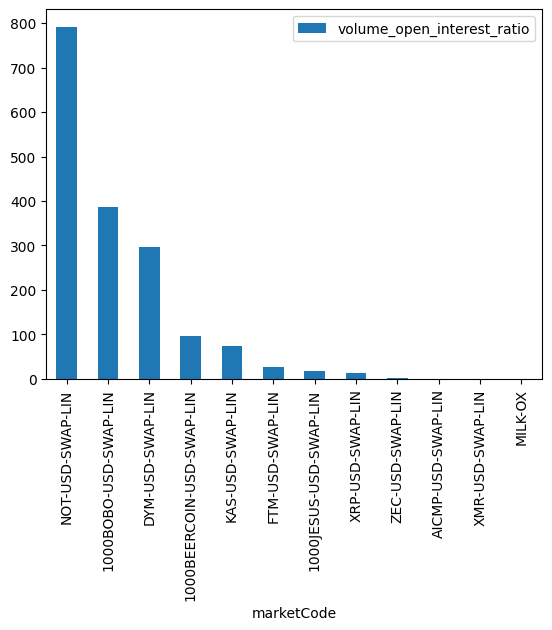

In [ ]:
# Plot OI/24h volume
close_to_24h_high['volume_open_interest_ratio'] = close_to_24h_high['openInterest'] / close_to_24h_high['currencyVolume24h']
close_to_24h_high = close_to_24h_high.sort_values(by='volume_open_interest_ratio', ascending=False)
close_to_24h_high.plot(x='marketCode', y='volume_open_interest_ratio', kind='bar')

In [8]:
# get ticker history
ohlcv = ox_loader.get_ohlcv_for_list_of_marketCodes(tickers['marketCode'].tolist())


Fetched OHLCV data for 1000PEPE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for KEKIUS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TIA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PURR-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DEAI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for FAI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CATANA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GROK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:15:11,552 - interface.ox - INFO - No more data for ANDY70B-USD-SWAP-LIN
INFO:interface.ox:No more data for ANDY70B-USD-SWAP-LIN


Fetched OHLCV data for ANDY70B-USD-SWAP-LIN from 2024-12-19 21:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for UNI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TORN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LUIGI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DINERO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:15:23,735 - interface.ox - INFO - No more data for FARM-USD-SWAP-LIN
INFO:interface.ox:No more data for FARM-USD-SWAP-LIN


Fetched OHLCV data for FARM-USD-SWAP-LIN from 2025-01-03 02:00:00 to 2025-01-08 08:00:00


2025-01-08 08:15:26,311 - interface.ox - INFO - No more data for GOUT-USD-SWAP-LIN
INFO:interface.ox:No more data for GOUT-USD-SWAP-LIN


Fetched OHLCV data for GOUT-USD-SWAP-LIN from 2024-12-24 02:00:00 to 2025-01-08 08:00:00


2025-01-08 08:15:27,453 - interface.ox - INFO - No more data for PYTHIA-USD-SWAP-LIN
INFO:interface.ox:No more data for PYTHIA-USD-SWAP-LIN


Fetched OHLCV data for PYTHIA-USD-SWAP-LIN from 2025-01-03 03:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DOGEGOVSOL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for STNK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ETC-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for W-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for YES-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:15:42,103 - interface.ox - INFO - No more data for CUMMIES-USD-SWAP-LIN
INFO:interface.ox:No more data for CUMMIES-USD-SWAP-LIN


Fetched OHLCV data for CUMMIES-USD-SWAP-LIN from 2024-12-25 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SPX-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for wQUIL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ORCA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ANON-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for EMP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000BONK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MICHI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SHIRO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for XTZ-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:16:04,921 - interface.ox - INFO - No more data for OX-USDT
INFO:interface.ox:No more data for OX-USDT


Fetched OHLCV data for OX-USDT from 2024-12-25 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for KWEEN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BARSIK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:16:10,197 - interface.ox - INFO - No more data for MOODENGETH-USD-SWAP-LIN
INFO:interface.ox:No more data for MOODENGETH-USD-SWAP-LIN


Fetched OHLCV data for MOODENGETH-USD-SWAP-LIN from 2024-12-26 02:00:00 to 2025-01-08 08:00:00


2025-01-08 08:16:11,064 - interface.ox - INFO - No more data for AICMP-USD-SWAP-LIN
INFO:interface.ox:No more data for AICMP-USD-SWAP-LIN


Fetched OHLCV data for AICMP-USD-SWAP-LIN from 2025-01-06 19:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MYRO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CFX-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SUNDOG-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PEPECOIN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ACX-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HEHE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RAPR-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ALCH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for JEFF-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BOBAOPPA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLC

2025-01-08 08:16:44,929 - interface.ox - INFO - No more data for USDT-USD-SWAP-LIN
INFO:interface.ox:No more data for USDT-USD-SWAP-LIN


Fetched OHLCV data for USDT-USD-SWAP-LIN from 2024-12-25 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:16:46,744 - interface.ox - INFO - No more data for YNE-USD-SWAP-LIN
INFO:interface.ox:No more data for YNE-USD-SWAP-LIN


Fetched OHLCV data for YNE-USD-SWAP-LIN from 2024-12-24 23:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for POL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for OP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RUNE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ZK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PEAS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RATS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for KUJI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HYPE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000BOBO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CAH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for A

2025-01-08 08:17:15,340 - interface.ox - INFO - No more data for SWARMS-USD-SWAP-LIN
INFO:interface.ox:No more data for SWARMS-USD-SWAP-LIN


Fetched OHLCV data for SWARMS-USD-SWAP-LIN from 2024-12-22 22:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RETARDIO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for UNFI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AURA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MOTHER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for WIF-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ACT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MEW-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SUI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MKR-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GNON-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data

2025-01-08 08:18:09,549 - interface.ox - INFO - No more data for ACOLYT-USD-SWAP-LIN
INFO:interface.ox:No more data for ACOLYT-USD-SWAP-LIN


Fetched OHLCV data for ACOLYT-USD-SWAP-LIN from 2024-12-22 15:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ZEC-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RDNT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 100000BABYDOGE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for STX-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:18:21,450 - interface.ox - INFO - No more data for MIRA-USD-SWAP-LIN
INFO:interface.ox:No more data for MIRA-USD-SWAP-LIN


Fetched OHLCV data for MIRA-USD-SWAP-LIN from 2024-12-26 01:00:00 to 2025-01-08 08:00:00


2025-01-08 08:18:23,910 - interface.ox - INFO - No more data for GT-USD-SWAP-LIN
INFO:interface.ox:No more data for GT-USD-SWAP-LIN


Fetched OHLCV data for GT-USD-SWAP-LIN from 2024-12-19 01:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for XLM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LDO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RON-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LUNAVIRTUALS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SEKOIA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:18:35,506 - interface.ox - INFO - No more data for BUTTHOLE-USD-SWAP-LIN
INFO:interface.ox:No more data for BUTTHOLE-USD-SWAP-LIN


Fetched OHLCV data for BUTTHOLE-USD-SWAP-LIN from 2024-12-30 08:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MONKY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SKBDI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SOL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000CHEEMS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HNT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:18:52,394 - interface.ox - INFO - No more data for BUILD-USD-SWAP-LIN
INFO:interface.ox:No more data for BUILD-USD-SWAP-LIN


Fetched OHLCV data for BUILD-USD-SWAP-LIN from 2025-01-06 02:00:00 to 2025-01-08 08:00:00


2025-01-08 08:18:53,755 - interface.ox - INFO - No more data for RAI-USD-SWAP-LIN
INFO:interface.ox:No more data for RAI-USD-SWAP-LIN


Fetched OHLCV data for RAI-USD-SWAP-LIN from 2024-12-24 16:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HIGHER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ZEREBRO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SAGA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000BEERCOIN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:19:06,312 - interface.ox - INFO - No more data for MILK-OX
INFO:interface.ox:No more data for MILK-OX


Fetched OHLCV data for MILK-OX from 2025-01-01 09:00:00 to 2025-01-08 04:00:00
Fetched OHLCV data for CRV-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NOT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SEI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LOL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:19:19,215 - interface.ox - INFO - No more data for VAPOR-USD-SWAP-LIN
INFO:interface.ox:No more data for VAPOR-USD-SWAP-LIN


Fetched OHLCV data for VAPOR-USD-SWAP-LIN from 2024-12-31 13:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000NEIRO1ETH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PANGBOY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LESTER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for WLD-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 3AC-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000PORK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for RENDER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PUPS2-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LUCE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BULLY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:20:32,577 - interface.ox - INFO - No more data for SPORE-USD-SWAP-LIN
INFO:interface.ox:No more data for SPORE-USD-SWAP-LIN


Fetched OHLCV data for SPORE-USD-SWAP-LIN from 2024-12-25 21:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000SHIB-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PENDLE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:20:38,640 - interface.ox - INFO - No more data for KOMA-USD-SWAP-LIN
INFO:interface.ox:No more data for KOMA-USD-SWAP-LIN


Fetched OHLCV data for KOMA-USD-SWAP-LIN from 2025-01-03 02:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for XYO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000HOPPY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MURAD-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LUM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MAV-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BAN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:20:55,564 - interface.ox - INFO - No more data for KIKI-USD-SWAP-LIN
INFO:interface.ox:No more data for KIKI-USD-SWAP-LIN


Fetched OHLCV data for KIKI-USD-SWAP-LIN from 2024-12-22 01:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ALT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AGLD-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DINO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MINI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TSOTCHKE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for VISTA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BTC-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DEGOD-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:21:19,386 - interface.ox - INFO - No more data for CPOOL-USD-SWAP-LIN
INFO:interface.ox:No more data for CPOOL-USD-SWAP-LIN


Fetched OHLCV data for CPOOL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LOCKIN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CREAM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000COQ-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SHRUBETH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TRX-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NUB-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MANTA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BERT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for FTT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000WUF-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched O

2025-01-08 08:21:50,584 - interface.ox - INFO - No more data for MILADY-USD-SWAP-LIN
INFO:interface.ox:No more data for MILADY-USD-SWAP-LIN


Fetched OHLCV data for MILADY-USD-SWAP-LIN from 2025-01-01 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CULT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BULL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BRETT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DRIFT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MIZUKI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BANANA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AVAX-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SHFL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DEGEN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PNUT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLC

2025-01-08 08:23:04,417 - interface.ox - INFO - No more data for SNAI-USD-SWAP-LIN
INFO:interface.ox:No more data for SNAI-USD-SWAP-LIN


Fetched OHLCV data for SNAI-USD-SWAP-LIN from 2024-12-22 12:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for WOLF-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BLAST-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SCF-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AIXBT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NEAR-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for APT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MOVE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MERL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for EACC-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 10000CAW-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:23:32,896 - interface.ox - INFO - No more data for CONVO-USD-SWAP-LIN
INFO:interface.ox:No more data for CONVO-USD-SWAP-LIN


Fetched OHLCV data for CONVO-USD-SWAP-LIN from 2025-01-07 02:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PYTH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DMAGA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PENGU-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ARB-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DADDY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DOG-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PUMPFUN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ID-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GIGA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for VADER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV dat

2025-01-08 08:24:12,512 - interface.ox - INFO - No more data for GMT-USD-SWAP-LIN
INFO:interface.ox:No more data for GMT-USD-SWAP-LIN


Fetched OHLCV data for GMT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for VIRTUAL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TROY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GIKO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PUNK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for KEYCAT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ANSEM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HIPPO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HAWKTUAH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TAO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PIPPIN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OH

2025-01-08 08:24:44,847 - interface.ox - INFO - No more data for AIXCB-USD-SWAP-LIN
INFO:interface.ox:No more data for AIXCB-USD-SWAP-LIN


Fetched OHLCV data for AIXCB-USD-SWAP-LIN from 2024-12-18 15:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SIMMI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for EIGEN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000JESUS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ORDER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ELIZA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SCR-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:25:01,395 - interface.ox - INFO - No more data for BIO-USD-SWAP-LIN
INFO:interface.ox:No more data for BIO-USD-SWAP-LIN


Fetched OHLCV data for BIO-USD-SWAP-LIN from 2025-01-03 06:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ETH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for COBY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SEND-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:25:08,913 - interface.ox - INFO - No more data for OX-USDC
INFO:interface.ox:No more data for OX-USDC


Fetched OHLCV data for OX-USDC from 2024-12-25 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TRUMP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DOLAN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LUMIA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:25:17,635 - interface.ox - INFO - No more data for CHEX-USD-SWAP-LIN
INFO:interface.ox:No more data for CHEX-USD-SWAP-LIN


Fetched OHLCV data for CHEX-USD-SWAP-LIN from 2024-12-25 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MEME-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for APU-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for REDO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GAME-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:25:29,517 - interface.ox - INFO - No more data for LEXICON-USD-SWAP-LIN
INFO:interface.ox:No more data for LEXICON-USD-SWAP-LIN


Fetched OHLCV data for LEXICON-USD-SWAP-LIN from 2025-01-03 02:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for STRK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HFUN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for XRP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:25:38,231 - interface.ox - INFO - No more data for DUNA-USD-SWAP-LIN
INFO:interface.ox:No more data for DUNA-USD-SWAP-LIN


Fetched OHLCV data for DUNA-USD-SWAP-LIN from 2025-01-03 02:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SHOGGOTH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:25:41,530 - interface.ox - INFO - No more data for XMR-USD-SWAP-LIN
INFO:interface.ox:No more data for XMR-USD-SWAP-LIN


Fetched OHLCV data for XMR-USD-SWAP-LIN from 2025-01-03 03:00:00 to 2025-01-08 05:00:00
Fetched OHLCV data for SUN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LMEOW-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NEIRO1-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000GINNAN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for FRED-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GME-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AXL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MIGGLES-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000MAGA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NOTICKER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetch

2025-01-08 08:26:22,443 - interface.ox - INFO - No more data for PHA-USD-SWAP-LIN
INFO:interface.ox:No more data for PHA-USD-SWAP-LIN


Fetched OHLCV data for PHA-USD-SWAP-LIN from 2025-01-01 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for REI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ARC-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NLK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LINGO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AERO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ORDI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BIFI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SXP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LUNA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BEAM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:26:51,659 - interface.ox - INFO - No more data for BANANABSC-USD-SWAP-LIN
INFO:interface.ox:No more data for BANANABSC-USD-SWAP-LIN


Fetched OHLCV data for BANANABSC-USD-SWAP-LIN from 2024-12-24 02:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for WOO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000ANDY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CAKE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PAAL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for FRIEND-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BILLY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for INST-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for HYPERLIQUID-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for COW-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for API3-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetc

2025-01-08 08:28:32,805 - interface.ox - INFO - No more data for UFD-USD-SWAP-LIN
INFO:interface.ox:No more data for UFD-USD-SWAP-LIN


Fetched OHLCV data for UFD-USD-SWAP-LIN from 2024-12-18 19:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for FARTCOIN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BLUR-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for DOGEGOV-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SAND-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:28:44,633 - interface.ox - INFO - No more data for SHR-USD-SWAP-LIN
INFO:interface.ox:No more data for SHR-USD-SWAP-LIN


Fetched OHLCV data for SHR-USD-SWAP-LIN from 2024-12-25 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PIXEL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for GRASS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ALGO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for PIP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TREMP-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for MEMESAI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000WHY-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for OM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SIGMA-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ATOM-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV d

2025-01-08 08:29:43,757 - interface.ox - INFO - No more data for SEN-USD-SWAP-LIN
INFO:interface.ox:No more data for SEN-USD-SWAP-LIN


Fetched OHLCV data for SEN-USD-SWAP-LIN from 2024-12-28 04:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AEVO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for THE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for NEIROETH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for APE-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for BABYBNB-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SLERF-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for FIL-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CETUS-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00


2025-01-08 08:30:06,408 - interface.ox - INFO - No more data for MLG-USD-SWAP-LIN
INFO:interface.ox:No more data for MLG-USD-SWAP-LIN


Fetched OHLCV data for MLG-USD-SWAP-LIN from 2025-01-07 01:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for 1000MOG-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for ASTRO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for WOLFETH-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for XAI-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for JTO-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for TIGER-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for CKB-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for SHARKCAT-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for LINK-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched OHLCV data for AIMEMECOIN-USD-SWAP-LIN from 2024-12-18 09:00:00 to 2025-01-08 08:00:00
Fetched

In [ ]:
# Identify tickers above their 24h high according to QUOTED px 
rolling_highs = get_rolling_24h_high(ohlcv)
rolling_highs['above_high'] = rolling_highs['close'] >= rolling_highs['rolling_high']

# flag where current px > the rolling high 
# look at next period return, next 12h return, next 24h return 

C:\Users\doome\AppData\Local\Temp\ipykernel_1868\530842876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_marketCode['rolling_high'] = ohlcv_marketCode['close'].rolling(window=24).max()
C:\Users\doome\AppData\Local\Temp\ipykernel_1868\530842876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_marketCode['rolling_high'] = ohlcv_marketCode['close'].rolling(window=24).max()
C:\Users\doome\AppData\Local\Temp\ipykernel_1868\530842876.py:8: SettingWithCopyWarning: 
A value is trying to be set 

In [ ]:
returns = get_next_period_returns(rolling_highs)

C:\Users\doome\AppData\Local\Temp\ipykernel_1868\202699876.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_marketCode['next_period_return'] = ohlcv_marketCode['close'].pct_change().shift(-1)
C:\Users\doome\AppData\Local\Temp\ipykernel_1868\202699876.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ohlcv_marketCode['next_12h_return'] = ohlcv_marketCode['close'].pct_change(periods=12).shift(-12)
C:\Users\doome\AppData\Local\Temp\ipykernel_1868\202699876.py:10: SettingWithCopyWarning: 
A value is 

In [11]:
# plot next_period_return where current px is above the rolling 24h high 
returns_above_high = returns[returns['above_high'] == True]
# returns_above_high.plot(x='marketCode', y='next_period_return', kind='bar')

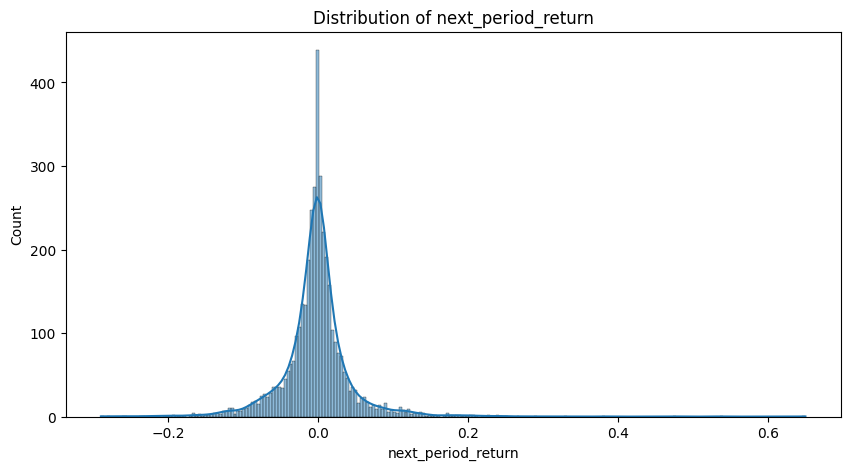

In [13]:
plots.plot_distribution(returns_above_high[returns_above_high['currencyVolume']> 0], 'next_period_return')

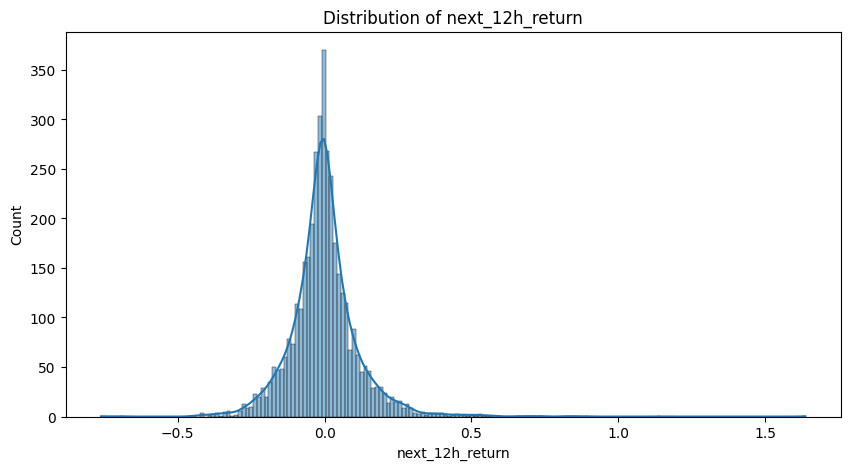

In [14]:
plots.plot_distribution(returns_above_high[returns_above_high['currencyVolume']> 0], 'next_12h_return')

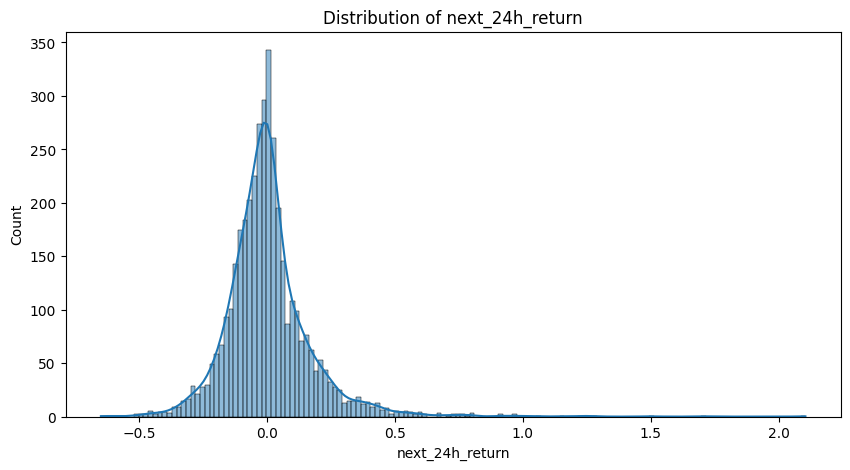

In [15]:
plots.plot_distribution(returns_above_high[returns_above_high['currencyVolume']> 0], 'next_24h_return')

In [ ]:
# get the latest datapoint for marketCode that are above the rolling 24h high 
max_openedAt = returns.groupby('marketCode')['openedAt'].idxmax()
returns_max_openedAt = returns.loc[max_openedAt]

returns_max_openedAt[returns_max_openedAt['above_high'] == True]

,open,high,low,close,volume,currencyVolume,openedAt,marketCode,rolling_high,above_high,next_period_return,next_12h_return,next_24h_return
128701,0.092980,0.101320,0.092980,0.101190,0.0,0.0,1736341200000,1000MAGA-USD-SWAP-LIN,0.101190,True,NaN,NaN,NaN
130219,0.007122,0.007286,0.007122,0.007207,0.0,0.0,1736341200000,BIAOSOL-USD-SWAP-LIN,0.007207,True,NaN,NaN,NaN
107923,3.857900,3.935000,3.815100,3.935000,0.0,0.0,1736341200000,GIKO-USD-SWAP-LIN,3.935000,True,NaN,NaN,NaN
49696,0.035000,0.035000,0.035000,0.035000,0.0,0.0,1736326800000,MILK-OX,0.035000,True,NaN,NaN,NaN
19817,15.450000,15.450000,15.450000,15.450000,0.0,0.0,1736341200000,RAPR-USD-SWAP-LIN,15.450000,True,NaN,NaN,NaN


In [28]:
# select symbols above their historical high in the last 5h window 

window = 5

historical_highs = get_historical_high(returns)
# max_openedAt_hist_high = historical_highs.groupby('marketCode')['openedAt'].idxmax()
historical_highs['above_historical_high'] = historical_highs['close'] >= historical_highs['historical_high']
historical_highs[(historical_highs['above_historical_high'] == True)  & (historical_highs['openedAt'] >= historical_highs['openedAt'].max() - window*3600*1000)]

,open,high,low,close,volume,currencyVolume,openedAt,marketCode,rolling_high,above_high,next_period_return,next_12h_return,next_24h_return,historical_high,above_historical_high
16270,0.041438,0.045022,0.040974,0.043038,0.000000e+00,0.0,1736323200000,AICMP-USD-SWAP-LIN,0.043038,True,0.081881,NaN,NaN,0.043006,True
16271,0.043254,0.048397,0.042400,0.046562,0.000000e+00,0.0,1736326800000,AICMP-USD-SWAP-LIN,0.046562,True,-0.048860,NaN,NaN,0.043038,True
16273,0.044261,0.049629,0.043204,0.049099,7.131906e+03,1549.0,1736334000000,AICMP-USD-SWAP-LIN,0.049099,True,-0.054217,NaN,NaN,0.046562,True
80082,0.000913,0.000933,0.000875,0.000930,0.000000e+00,0.0,1736334000000,1000WUF-USD-SWAP-LIN,0.000930,True,-0.017204,NaN,NaN,0.000924,True
180945,0.187240,0.213390,0.187170,0.205920,3.649257e+06,173514.0,1736330400000,AVA-USD-SWAP-LIN,0.205920,True,-0.031857,NaN,NaN,0.192200,True


In [ ]:
# historical_highs[(historical_highs['above_high'] == True) & (historical_highs['above_historical_high'] == True)]

,open,high,low,close,volume,currencyVolume,openedAt,marketCode,rolling_high,above_high,next_period_return,next_12h_return,next_24h_return,historical_high,above_historical_high
544,0.004220,0.004470,0.004020,0.004430,0.000,0.0,1734667200000,KEKIUS-USD-SWAP-LIN,0.004430,True,-0.079007,-0.137698,-0.266366,0.003900,True
715,0.004560,0.004950,0.004480,0.004710,0.000,0.0,1735279200000,KEKIUS-USD-SWAP-LIN,0.004710,True,0.027601,0.303609,0.634820,0.004430,True
716,0.004810,0.004840,0.003950,0.004840,0.000,0.0,1735282800000,KEKIUS-USD-SWAP-LIN,0.004840,True,0.450413,0.179752,0.795455,0.004710,True
717,0.004650,0.007020,0.004530,0.007020,0.000,0.0,1735286400000,KEKIUS-USD-SWAP-LIN,0.007020,True,-0.091168,-0.317664,0.155271,0.004840,True
733,0.005170,0.007120,0.005170,0.007120,0.000,0.0,1735344000000,KEKIUS-USD-SWAP-LIN,0.007120,True,-0.191011,0.144663,1.067416,0.007020,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180897,0.180230,0.188490,0.179950,0.188370,7382.232,396.0,1736157600000,AVA-USD-SWAP-LIN,0.188370,True,-0.023252,0.003716,-0.089770,0.183870,True
180899,0.184040,0.195220,0.184040,0.192200,0.000,0.0,1736164800000,AVA-USD-SWAP-LIN,0.192200,True,-0.019771,-0.079396,-0.111186,0.188370,True
180945,0.187240,0.213390,0.187170,0.205920,3649256.729,173514.0,1736330400000,AVA-USD-SWAP-LIN,0.205920,True,-0.031857,NaN,NaN,0.192200,True
181395,0.039518,0.041450,0.039486,0.041371,0.000,0.0,1736128800000,JOE-USD-SWAP-LIN,0.041371,True,-0.059269,0.003360,-0.072635,0.040945,True


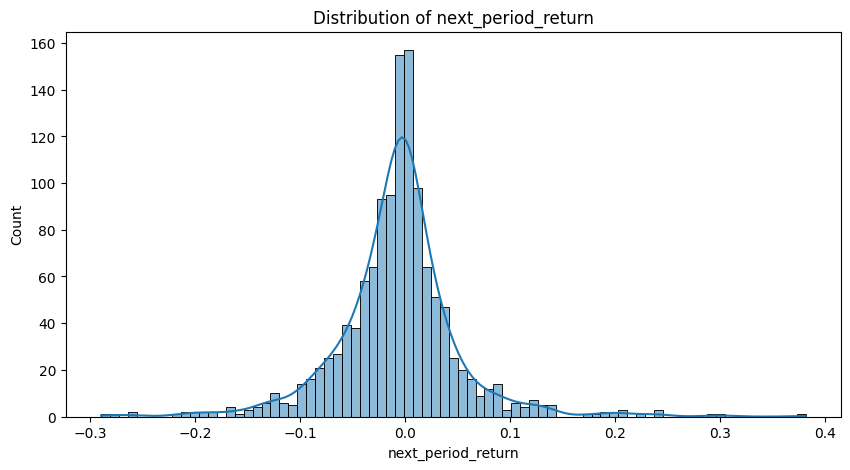

In [19]:
plots.plot_distribution(historical_highs[(historical_highs['currencyVolume'] > 0) & (historical_highs['above_historical_high'] == True)], 'next_period_return')

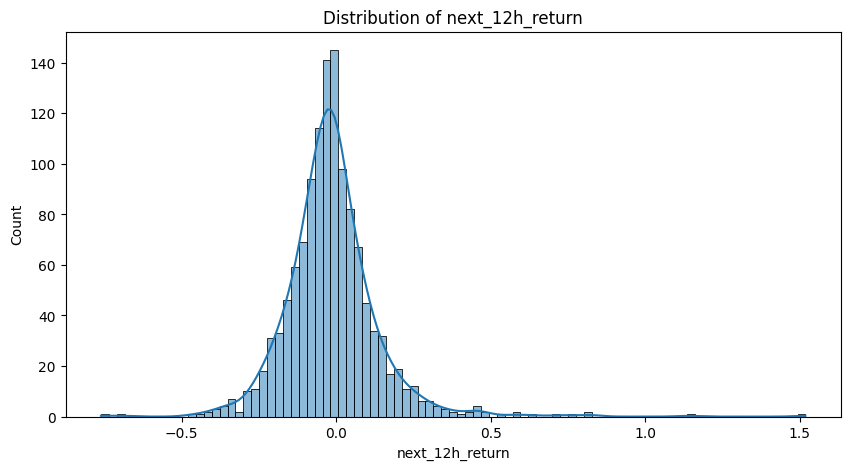

In [20]:
plots.plot_distribution(historical_highs[(historical_highs['currencyVolume'] > 0) & (historical_highs['above_historical_high'] == True)], 'next_12h_return')

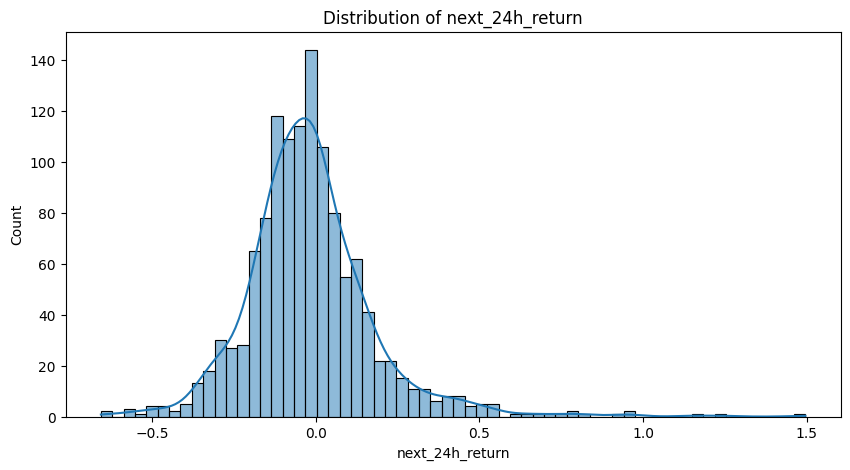

In [22]:
plots.plot_distribution(historical_highs[(historical_highs['currencyVolume'] > 0) & (historical_highs['above_historical_high'] == True)], 'next_24h_return')

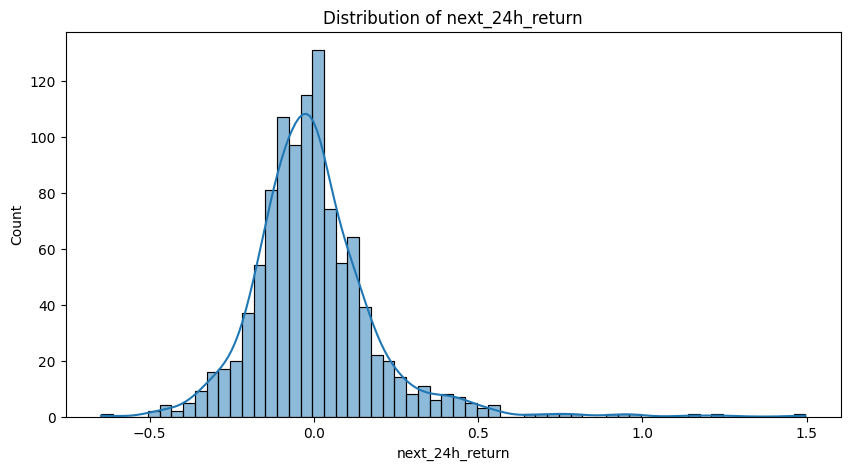

In [21]:
plots.plot_distribution(historical_highs[(historical_highs['currencyVolume'] > 0) & (historical_highs['above_historical_high'] == True) & (historical_highs['above_high'] == True)], 'next_24h_return')

In [ ]:
# seasonality in OX 

ox = ohlcv[ohlcv['marketCode'] == 'OX-USDT']
# convert openedAT to datetime
ox.loc[:,'openedAt'] = pd.to_datetime(ox['openedAt'].astype(float), unit='ms', origin='unix')

<Axes: xlabel='hour-of-day', ylabel='mean'>

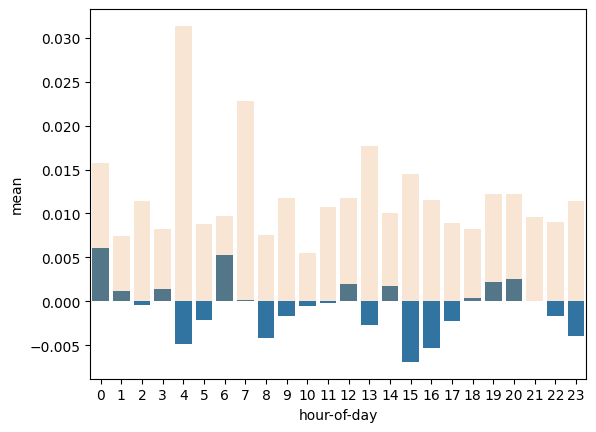

In [42]:
ox.loc[:,'hour-of-day'] = ox['openedAt'].dt.hour
ox.loc[:,'log_return'] = np.log(ox['close']).diff()

ox_agg = ox.groupby('hour-of-day')['log_return'].agg(['mean', 'std']).reset_index()

sns.barplot(x='hour-of-day', y='mean', data=ox_agg)
sns.barplot(x='hour-of-day', y='std', data=ox_agg, alpha=0.2)


<Axes: xlabel='openedAt', ylabel='cumsum_long_return'>

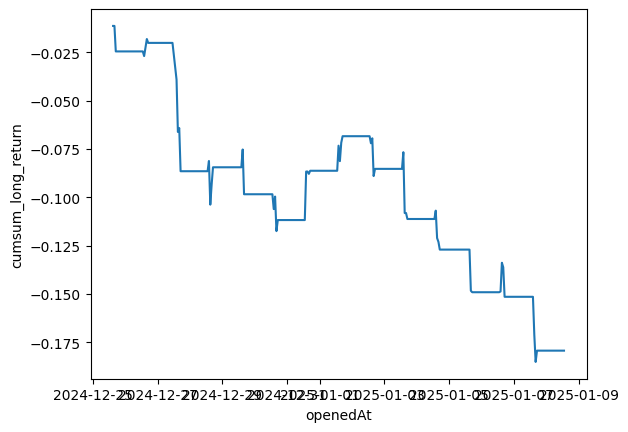

In [47]:
# add column long, 1 if hour = 0 else 0

ox.loc[:,'long'] = ox['hour-of-day'].apply(lambda x: 1 if 14 <= x <= 17 else 0)

ox.loc[:,'long_return'] = ox['long'] * ox['log_return']

# cumsum col of long return 
ox.loc[:,'cumsum_long_return'] = ox['long_return'].cumsum()

sns.lineplot(x='openedAt', y='cumsum_long_return', data=ox)